# The Battle of Coffee Shops
### Capstone Project for IBM Data Science professional certificate @ Coursera

## Contents

* [Introduction: Problem and background](#intro)
* [Data](#data)
    * [Getting the data](#getting_the_data)
    * [Exploratory data analysis](#exploratory_analysis)
* [Methodology](#method)
* [Classification model development](#model)
    * [Data preparation](#preparation)
    * [Model training](#training)
    * [Model testing](#testing)
* [Final deliverable - classified grid](#heatmap)
    * [Grid points](#grid_points)
    * [Foursquare venues for grid](#four_grid)
    * [OSM tags for grid](#osm_grid)
    * [Grid classification](#class_grid)
    * [Grid visualization](#class_visual)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## <a name="intro"></a>Introduction: Problem and background

In this project we are going to propose the optimal choice of coffee shop type for a given location. This study can be used by stakeholders who are interested in **coffee shop market in Warsaw**.

There are 2 ways to enter coffee shop market: you either buy franchise from a large chain or open an original coffeehouse.
- With franchise you'll get a fine tuned business model, brand and supply chain with prices negotiated for the large volumes
- With original coffeehouse you'll get an opportunity to make it from scratch

Interesting observation was made that a single location and small chain coffee shops co-exist with big chains.
They didn't disappear due to competition powered by the economy of scale.

Let's not talk about countries with ages of coffee culture (Italy) or top coffee drinkers (Finland).
We'll focus on Warsaw(Poland) where 2 big chains (Costa Coffee and Starbucks) are available.

There's the [study](https://www.safegraph.com/blog/local-vs-corporate-coffee) showing that people are most likely looking for different experience when going to a big chain coffeehouse compared to a single location/small chain.

Customer experience from the place is significantly defined by it's spatial context.

We'll be using data science tools to determine **how similar or dissimilar are spatial contexts for different types of coffee shops**. And **what type of coffee shop is the optimal choice for a given location represented by it's spatial conext**.

## <a name="data"></a>Data

According to [Tobler's first law of geography](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography): "everything is related to everything else, but near things are more related than distant things".
Following this idea will be doing study on spatial context of coffee shops in Warsaw.


[Foursquare City Guide API](https://foursquare.com/developers) will be used
- to obtain coffee shops locations in Warsaw
- to get spatial context for coffee shops - nearby venues

[OpenStreetMap (OSM)](https://www.openstreetmap.org/) data (obtained via [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API)) will be used to enrich spatial context data by bringing more map features to our dataset

[Geocoder](https://geocoder.readthedocs.io/) Python library will help to get coordinates for Warsaw districts

### <a name="getting_the_data"></a>Getting the data

In [2]:
#import required libs
import pandas as pd
import numpy as np
import geocoder
import requests
from bs4 import BeautifulSoup

#### Get Warsaw hoods

In [3]:
url_hoods = 'https://en.m.wikipedia.org/wiki/Districts_of_Warsaw'

r_hoods = requests.get(url_hoods)

soup = BeautifulSoup(r_hoods.text, 'html.parser')
tables = soup.find_all('table')
waw_hoods_soup = tables[1]

lis = []
for li in waw_hoods_soup.find_all('li'):
    lis.append(li.text)

waw_hoods = pd.DataFrame(lis) 
waw_hoods.columns = ['Hood']
waw_hoods.shape

(143, 1)

In [4]:
waw_hoods.head()

,Hood
0,Bemowo Lotnisko
1,Boernerowo
2,Chrzanów
3,Fort Bema
4,Fort Radiowo


#### Warsaw hoods geocoding

In [5]:
hoods_coor = pd.DataFrame(columns = ['Hood', 'Lat', 'Lon'])
hoods_coor

,Hood,Lat,Lon


In [6]:
for hood in waw_hoods['Hood']:
    g = geocoder.osm(hood + ', Warszawa')
    hoods_coor = hoods_coor.append({'Hood':hood, 'Lat':g.lat, 'Lon':g.lng}, ignore_index=True)

In [9]:
hoods_coor.head()

,Hood,Lat,Lon
0,Bemowo Lotnisko,52.255412,20.916322
1,Boernerowo,52.262390,20.901451
2,Chrzanów,52.227788,20.885119
3,Fort Bema,52.259455,20.932728
4,Fort Radiowo,52.257211,20.891900


#### Get Coffee Shops via Foursquare API

In [578]:
#Foursquare API creds
CLIENT_ID = '?' # your Foursquare ID
CLIENT_SECRET = '?' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: ?
CLIENT_SECRET:?


We'll be gathering coffee shops with 2000m radius around geocoded hoods.

In [10]:
def getCoffeeShops(names, latitudes, longitudes, radius=2000):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL for Coffe Shop category (4bf58dd8d48988d1e0931735)
        url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d1e0931735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        # return only relevant information for each nearby venue
        venues_list.append([( 
            v.get('name'),
            v.get('id'),
            v.get('location').get('lat'), 
            v.get('location').get('lng')) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [ 
                  'Coffee Shop',
                  'Coffee Shop ID',
                  'Coffee Shop Latitude', 
                  'Coffee Shop Longitude']
    
    return(nearby_venues)

In [12]:
coffee_shops = getCoffeeShops(names=hoods_coor['Hood'],
                                   latitudes=hoods_coor['Lat'],
                                   longitudes=hoods_coor['Lon']
                                  )

Bemowo Lotnisko
Boernerowo
Chrzanów
Fort Bema
Fort Radiowo
Górce
Groty
Jelonki Północne
Jelonki Południowe
Lotnisko
Białołęka Dworska
Brzeziny
Choszczówka
Dąbrówka Szlachecka
Grodzisk
Henryków
Kobiałka
Nowodwory
Szamocin
Tarchomin
Żerań
Chomiczówka
Huta
Las Bielański
Młociny
Marymont-Kaskada
Marymont-Ruda
Piaski
Placówka
Radiowo
Słodowiec
Stare Bielany
Wólka Węglowa
Wawrzyszew
Wrzeciono
Augustówka
Czerniaków
Ksawerów
Służew
Służewiec
Sadyba
Siekierki
Sielce
Stary Mokotów
Stegny
Wierzbno
Wyględów
Filtry
Rakowiec
Stara Ochota
Szczęśliwice
Gocław
Gocławek
Grochów
Kamionek
Olszynka Grochowska
Saska Kępa
Nowa Praga
Pelcowizna
Stara Praga
Szmulowizna
Kawęczyn-Wygoda
Nowy Rembertów
Stary Rembertów
Muranów
Nowe Miasto
Powiśle
Solec
Stare Miasto
Śródmieście Północne
Śródmieście Południowe
Ujazdów
Elsnerów
Bródno
Bródno Podgrodzie
Targówek Fabryczny
Targówek Mieszkaniowy
Zacisze
Utrata
Czechowice
Gołąbki
Niedźwiadek
Skorosze
Szamoty
Dąbrówka
Grabów
Jeziorki Północne
Jeziorki Południowe
Kabaty
Na

In [13]:
coffee_shops.shape

(1812, 4)

Remove duplicates

In [15]:
#let's remove duplicates
coffee_shops.drop_duplicates(subset=['Coffee Shop ID'], inplace=True)
coffee_shops.reset_index(inplace=True)

In [17]:
coffee_shops = coffee_shops[['Coffee Shop', 'Coffee Shop ID', 'Coffee Shop Latitude', 'Coffee Shop Longitude']]

In [18]:
coffee_shops.shape

(349, 4)

In [21]:
coffee_shops.head()

,Coffee Shop,Coffee Shop ID,Coffee Shop Latitude,Coffee Shop Longitude
0,Costa Coffee,5a772ca79e3b651f75afa07f,52.251903,20.914894
1,Green Cafè Nero,55fb03ea498ee6e567d9c8a5,52.241689,20.933347
2,Cafe Jurta Forty Bema,51bc1bd2e4b0b8711bf6d302,52.257985,20.935512
3,Costa Coffee,55e408fa498ee04c0e6c54c5,52.239894,20.906116
4,Mc Cafe,51725bb8e4b09fc933c2594a,52.239288,20.898000


#### Get Foursquare venues for coffee shops

We'll be gathering venues with 500m radius around geocoded coffee shops.

In [24]:
def getNearbyVenues(names, ids, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    venues_list=[]
    for name, cs_id, lat, lng in zip(names, ids, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            cs_id, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Coffee Shop', 
                  'Coffee Shop ID', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
venues = getNearbyVenues(names=coffee_shops['Coffee Shop'], ids=coffee_shops['Coffee Shop ID'],
                                   latitudes=coffee_shops['Coffee Shop Latitude'],
                                   longitudes=coffee_shops['Coffee Shop Longitude']
                                  )

Costa Coffee
Green Cafè Nero
Cafe Jurta Forty Bema
Costa Coffee
Mc Cafe
My Coffee
Słodki Karmel
Costa Coffee
Księgarnia im. Krzysztofa Kamila Baczyńskiego
Kawowiec
Kawadzieścia
Kawiarnia Spotkanie
Sucré- Lody naturalne
Cieślikowski Cukiernia
CoffeeLab
Costa Coffee
Starbucks Targówek
Black Cafe
Saint Honore
Costa Coffee
Ceramiczna Cafe Bar
Starbucks
Stacja Bielany
Costa Coffee
Dlaczemu
Costa Coffee
Dr Kava
Drugie Piętro
Przystanek Piekarnia
Czytelnia
Java Coffee Company
Cafe Bar Havana
Doza Café
Sady Cafe
Kalimba Kofifi
CoffeeDay
Kawka Na Ławkę By Cophi
Costa Coffee
Nespresso Pop-up Boutique
Starbucks
Tchibo
Dallmayr Cafe & Bar
Costa Coffee
Empik Cafe
Apresso
Być Może
Relaks
Green Caffè Nero
for.rest design
Green Caffè Nero
Hygge
Gazeta Cafe
Cafè Nazaret
Po Drodze
Po Drødze
kolarski.eu
kawiarnia spacerówka
Owoc Ma Moc
Cafe Chełmska
Tornado Café
Goraco polecam Nowakowski
Costa Coffee
Starbucks
Buongiorno coffee
Służę Kawą
Kawopój / 9p.
Cophi Stand
Fresh Market
Costa Coffee
La Cafeteria
T

In [26]:
venues.shape

(12858, 6)

In [29]:
venues.head()

,Coffee Shop,Coffee Shop ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Costa Coffee,5a772ca79e3b651f75afa07f,Aplauz Fitness Klub,52.252039,20.913148,Gym
1,Costa Coffee,5a772ca79e3b651f75afa07f,Costa Coffee,52.251903,20.914894,Coffee Shop
2,Costa Coffee,5a772ca79e3b651f75afa07f,Restauracja Latisana,52.254922,20.919364,Italian Restaurant
3,Costa Coffee,5a772ca79e3b651f75afa07f,Bajkolandia,52.247889,20.915371,Playground
4,Costa Coffee,5a772ca79e3b651f75afa07f,Biedronka,52.250767,20.914602,Supermarket


#### Get OSM data for coffee shops

We'll be gathering osm_tags (map features) with 500m radius around geocoded coffee shops.

In [36]:
def getOSMTags(names, ids, latitudes, longitudes, radius=500.0):
    name_list = []
    cs_id_list = []
    tag_keys_list=[]
    tag_values_list=[]
    
    for name, cs_id, lat, lng in zip(names, ids, latitudes, longitudes):
        print(name, cs_id)
        
        
        # create Overpass API request URL
        overpass_url = "http://overpass-api.de/api/interpreter"
        overpass_query = """
        [out:json];
        node(around:{},{},{});
        out;
        """.format(radius, lat, lng)
        
        # query data
        
        response = requests.get(overpass_url, 
                        params={'data': overpass_query})
        data = response.json()
        
        #parse data
        for element in data.get('elements'):
            if element.get('tags') == None:
                continue
            tag_keys_list = tag_keys_list + list(element.get('tags').keys())
            tag_values_list = tag_values_list + list(element.get('tags').values())
            for tag in element.get('tags').keys():
                name_list.append(name)
                cs_id_list.append(cs_id)

    
    #creat output df    
    kv_df = pd.DataFrame(columns = ['Coffee Shop', 'Coffee Shop ID', 'Key', 'Value'])
    kv_df['Key'] = tag_keys_list
    kv_df['Value'] = tag_values_list
    kv_df['Coffee Shop'] = name_list
    kv_df['Coffee Shop ID'] = cs_id_list

    return(kv_df)

In [38]:
coffee_shops_osm_tags = getOSMTags(names=coffee_shops['Coffee Shop'],ids=coffee_shops['Coffee Shop ID'], 
                      latitudes=coffee_shops['Coffee Shop Latitude'],longitudes=coffee_shops['Coffee Shop Longitude'])

Costa Coffee 5a772ca79e3b651f75afa07f
Green Cafè Nero 55fb03ea498ee6e567d9c8a5
Cafe Jurta Forty Bema 51bc1bd2e4b0b8711bf6d302
Costa Coffee 55e408fa498ee04c0e6c54c5
Mc Cafe 51725bb8e4b09fc933c2594a
My Coffee 5a3ac30db1ec132f28297235
Słodki Karmel 5ad20f696bd36b33d0e0df0e
Costa Coffee 4f2fd225e4b0efbc1246693e
Księgarnia im. Krzysztofa Kamila Baczyńskiego 515d9597e4b0fab8a13b6ff7
Kawowiec 5b13ab9dbed483002c0679bc
Kawadzieścia 5bc9c76ce1f0aa002c6514ed
Kawiarnia Spotkanie 5b263b153fcee8002ca47107
Sucré- Lody naturalne 597359a94a7aae59a88328bb
Cieślikowski Cukiernia 5c798084c62b49002c893ccd
CoffeeLab 53add661498eeba73df8fc3b
Costa Coffee 531efb1d11d217c5971e5c1c
Starbucks Targówek 585e5a2324ca6a3c7658e428
Black Cafe 5040c2a2e4b09ae79b22788f
Saint Honore 5a116ab88173cb23907844af
Costa Coffee 5a44bb499fca562e830589ea
Ceramiczna Cafe Bar 5a6e142aad178913efd2001b
Starbucks 5a23dc731b0ea53adbdb312c
Stacja Bielany 5374d620498e3acf9e6e208d
Costa Coffee 5cfaaf6ad552c7002d0f4ebb
Dlaczemu 5c0d66b6475a

Costa Coffee 5a9832ed9ba3e50242843bea
Klubokawiarnia ITePe 5cd576831acf11002cc54596
Starbucks 4d9dcf9a5c33a35d73c709a1
Kuchniaaa 5220acdb11d28f92fa1f7717
Laguna bar 51d29a8b498e4a191e58df7e
Panda's Kitchen 5256e91211d27755fdd17246
Kawiarnia Waszyngton 5f26aa1c4c9b8a2736ed096b
kawa & zabawa 57092935498e2c6e78fc80f5
Kawiarnia Waszyngton 5f2689b871da594e2f50a75f
Cafe Mińska 5ef4a8dab734a8000712cda8
No I Co 58396a83424f9379719e050b
U Krawca Cafe 4f2a3a33e4b0a328b738f009
Green Caffee Nero Express 50fc1573e4b04f85589ded41
coffeeheaven, Biblioteka UW 53343b37498e95b883187078
Proces Kawki 5b7e8cce464d65002c71babd
Costa Coffee 50096d42e4b02b1cbad3d27f
Nowa Fala 5b40fbc1bed483002cadccba
Warszawski Barista 550938b9498e5aed2a1c0a99
GRYCAN 55b5019e498ed94ddbe063dd
Hałas Vinyl + Coffee Saska Kępa 5c56f0c2b9ac38002c73da0b
Costa Coffee 5686669e498e8ac533e6a335
Gold Coffee 5ba8a02d12c8f0002c802625
Crepe Cafe 595a09fca9fe12131dd8eff8
Costa Coffee 5bddabd8bed483002c2d6a5e
Bistro Przystanek 51432aefe4b09c

In [39]:
coffee_shops_osm_tags.shape

(848594, 4)

In [40]:
coffee_shops_osm_tags.head()

,Coffee Shop,Coffee Shop ID,Key,Value
0,Costa Coffee,5a772ca79e3b651f75afa07f,highway,traffic_signals
1,Costa Coffee,5a772ca79e3b651f75afa07f,highway,traffic_signals
2,Costa Coffee,5a772ca79e3b651f75afa07f,highway,traffic_signals
3,Costa Coffee,5a772ca79e3b651f75afa07f,highway,traffic_signals
4,Costa Coffee,5a772ca79e3b651f75afa07f,highway,traffic_signals


In [42]:
coffee_shops_osm_tags['KV'] = coffee_shops_osm_tags['Key'] + ':' + coffee_shops_osm_tags['Value']
coffee_shops_osm_tags.head()

,Coffee Shop,Coffee Shop ID,Key,Value,KV
0,Costa Coffee,5a772ca79e3b651f75afa07f,highway,traffic_signals,highway:traffic_signals
1,Costa Coffee,5a772ca79e3b651f75afa07f,highway,traffic_signals,highway:traffic_signals
2,Costa Coffee,5a772ca79e3b651f75afa07f,highway,traffic_signals,highway:traffic_signals
3,Costa Coffee,5a772ca79e3b651f75afa07f,highway,traffic_signals,highway:traffic_signals
4,Costa Coffee,5a772ca79e3b651f75afa07f,highway,traffic_signals,highway:traffic_signals


Some cleaning of OSM tags data

In [45]:
# there are map features tagged with name, address, website, etc - not expected to bring much spatial context
# also there are rare tags creating noise
coffee_shops_osm_tags['KV'].value_counts()

addr:city:Warszawa                                                                                     43470
barrier:bollard                                                                                        34713
natural:tree                                                                                           31963
highway:crossing                                                                                       30145
highway:street_lamp                                                                                    15522
addr:city:simc:0918123                                                                                 13246
source:addr:mapa.um.warszawa.pl                                                                        13182
network:ZTM Warszawa                                                                                   10043
crossing:traffic_signals                                                                                7670
barrier:gate       

In [46]:
# let's clean tags a bit

# remove rare (<50 samples) tags
osm_tags_counts = coffee_shops_osm_tags['KV'].value_counts()
osm_tags_clean = coffee_shops_osm_tags[~coffee_shops_osm_tags['KV'].isin(osm_tags_counts[osm_tags_counts < 50].index)]

# remove tech tags and address/name/phone/etc.. 
osm_tags_clean = osm_tags_clean[~osm_tags_clean['KV'].str.contains('name')]
osm_tags_clean = osm_tags_clean[~osm_tags_clean['KV'].str.contains('addr')]
osm_tags_clean = osm_tags_clean[~osm_tags_clean['KV'].str.contains('phone')]
osm_tags_clean = osm_tags_clean[~osm_tags_clean['KV'].str.contains('email')]
osm_tags_clean = osm_tags_clean[~osm_tags_clean['KV'].str.contains('ref')]
osm_tags_clean = osm_tags_clean[~osm_tags_clean['KV'].str.contains('source')]
osm_tags_clean = osm_tags_clean[~osm_tags_clean['KV'].str.contains('created_by')]
osm_tags_clean = osm_tags_clean[~osm_tags_clean['KV'].str.contains('opening_hours')]
osm_tags_clean = osm_tags_clean[~osm_tags_clean['KV'].str.contains('website')]
osm_tags_clean = osm_tags_clean[~osm_tags_clean['KV'].str.contains('fax')]


In [47]:
osm_tags_clean['KV'].value_counts()
#~600 tags left, looks ok

barrier:bollard                                    34713
natural:tree                                       31963
highway:crossing                                   30145
highway:street_lamp                                15522
network:ZTM Warszawa                               10043
crossing:traffic_signals                            7670
barrier:gate                                        7564
tactile_paving:yes                                  7425
amenity:restaurant                                  7296
public_transport:stop_position                      7144
bus:yes                                             7019
level:-1                                            6981
wheelchair:yes                                      6874
amenity:bench                                       6406
crossing:uncontrolled                               6399
door:yes                                            6062
amenity:waste_basket                                5475
highway:bus_stop               

### <a name="exploratory_analysis"></a>Exploratory data analysis

#### First look

In [520]:
coffee_shops['Coffee Shop'].value_counts().head()

Costa Coffee            67
Green Caffè Nero        22
Starbucks               21
Tchibo                   4
Kawiarnia Waszyngton     2
Name: Coffee Shop, dtype: int64

Looks like we have at least 3 big chains - Costa, Starbucks and Green Cafe Nero

#### Manual classification

Let's manually classify coffee shops to have a look on insights per class

In [81]:
# manual classification - Costa, Nero, Starbucks = 0 (Big Chains), others = 1
cs_classes = []
for cs in coffee_shops['Coffee Shop']:
    if 'costa' in cs.lower():
        cs_classes.append(0)
    elif 'nero' in cs.lower():
        cs_classes.append(0)
    elif 'starbucks' in cs.lower():
        cs_classes.append(0)
    else:
        cs_classes.append(1)
    

In [83]:
len(cs_classes)

349

In [126]:
coffee_shops_class = coffee_shops.copy()
coffee_shops_class.insert(0, 'Manual Labels', cs_classes)

In [127]:
coffee_shops_class['Manual Labels'].value_counts()

1    228
0    121
Name: Manual Labels, dtype: int64

In [128]:
coffee_shops_class.head()

,Manual Labels,Coffee Shop,Coffee Shop ID,Coffee Shop Latitude,Coffee Shop Longitude
0,0,Costa Coffee,5a772ca79e3b651f75afa07f,52.251903,20.914894
1,0,Green Cafè Nero,55fb03ea498ee6e567d9c8a5,52.241689,20.933347
2,1,Cafe Jurta Forty Bema,51bc1bd2e4b0b8711bf6d302,52.257985,20.935512
3,0,Costa Coffee,55e408fa498ee04c0e6c54c5,52.239894,20.906116
4,1,Mc Cafe,51725bb8e4b09fc933c2594a,52.239288,20.898000


#### Insights

In [521]:
# we'll need to plot and map the things
import matplotlib.pyplot as plt
import folium

Number of features per coffee shop (both venes and OSM tags) will represent density of city - city center vs outskirts

In [129]:
venues.head()

,Coffee Shop,Coffee Shop ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Costa Coffee,5a772ca79e3b651f75afa07f,Aplauz Fitness Klub,52.252039,20.913148,Gym
1,Costa Coffee,5a772ca79e3b651f75afa07f,Costa Coffee,52.251903,20.914894,Coffee Shop
2,Costa Coffee,5a772ca79e3b651f75afa07f,Restauracja Latisana,52.254922,20.919364,Italian Restaurant
3,Costa Coffee,5a772ca79e3b651f75afa07f,Bajkolandia,52.247889,20.915371,Playground
4,Costa Coffee,5a772ca79e3b651f75afa07f,Biedronka,52.250767,20.914602,Supermarket


In [131]:
coffee_shops_class = pd.merge(coffee_shops_class, venues[['Coffee Shop ID', 'Venue']].groupby(['Coffee Shop ID']).count(), on='Coffee Shop ID')

In [134]:
coffee_shops_class['Venue'].sum()

12858

In [135]:
coffee_shops_class = pd.merge(coffee_shops_class, osm_tags_clean[['Coffee Shop ID', 'KV']].groupby(['Coffee Shop ID']).count(), on='Coffee Shop ID')

In [172]:
coffee_shops_class['KV'].sum()

432554

In [174]:
coffee_shops_class.rename(columns={'Venue': 'Venues Sum', 'KV': 'OSM Tags Sum'}, inplace=True)

In [175]:
coffee_shops_class.head()

,Manual Labels,Coffee Shop,Coffee Shop ID,Coffee Shop Latitude,Coffee Shop Longitude,Venues Sum,OSM Tags Sum
0,0,Costa Coffee,5a772ca79e3b651f75afa07f,52.251903,20.914894,9,610
1,0,Green Cafè Nero,55fb03ea498ee6e567d9c8a5,52.241689,20.933347,29,795
2,1,Cafe Jurta Forty Bema,51bc1bd2e4b0b8711bf6d302,52.257985,20.935512,10,212
3,0,Costa Coffee,55e408fa498ee04c0e6c54c5,52.239894,20.906116,7,458
4,1,Mc Cafe,51725bb8e4b09fc933c2594a,52.239288,20.898000,6,554


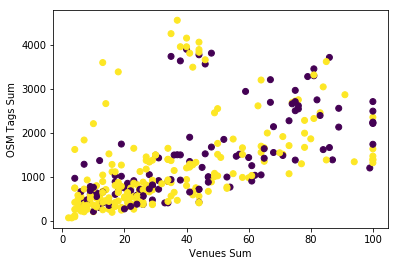

In [179]:
plt.scatter(x=coffee_shops_class['Venues Sum'], y=coffee_shops_class['OSM Tags Sum'], 
            c=(coffee_shops_class['Manual Labels'].to_numpy()+3)/10)
plt.xlabel('Venues Sum', fontsize=10)
plt.ylabel('OSM Tags Sum', fontsize=10)

plt.show()

Observation 1: both classess are available in every density level.

In [523]:
coffee_shops_class_map = coffee_shops_class.copy()

In [525]:
manual_cl_colors = []
for c in coffee_shops_class_map['Manual Labels']:
    if c==0:
        manual_cl_colors.append('red')
    else:
        manual_cl_colors.append('green')
coffee_shops_class_map['Colors'] = manual_cl_colors
coffee_shops_class_map.head()

,Manual Labels,Coffee Shop,Coffee Shop ID,Coffee Shop Latitude,Coffee Shop Longitude,Venues Sum,OSM Tags Sum,Colors
0,0,Costa Coffee,5a772ca79e3b651f75afa07f,52.251903,20.914894,9,610,red
1,0,Green Cafè Nero,55fb03ea498ee6e567d9c8a5,52.241689,20.933347,29,795,red
2,1,Cafe Jurta Forty Bema,51bc1bd2e4b0b8711bf6d302,52.257985,20.935512,10,212,green
3,0,Costa Coffee,55e408fa498ee04c0e6c54c5,52.239894,20.906116,7,458,red
4,1,Mc Cafe,51725bb8e4b09fc933c2594a,52.239288,20.898000,6,554,green


<a name="map_all_cs"></a>Map

In [575]:
# create map
map_waw = folium.Map(location=[coffee_shops_class_map['Coffee Shop Latitude'].mean(), 
                                   coffee_shops_class_map['Coffee Shop Longitude'].mean()], zoom_start=12)


# add markers to the map
for lat, lon, shop, cs_class, col in zip(coffee_shops_class_map['Coffee Shop Latitude'], coffee_shops_class_map['Coffee Shop Longitude'], coffee_shops_class_map['Coffee Shop'], coffee_shops_class_map['Manual Labels'], coffee_shops_class_map['Colors']):
    label = folium.Popup(str(shop) + ' Cluster ' + str(cs_class), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7).add_to(map_waw)

map_waw

Observation 2: there are areas where single location/small chain coffee shops (marked green on map) co-exist with big chains (marked red). In these cases spatial context will be the same and we won't be able to separate these cases based only on map features.

## <a name="method"></a>Methodology

In this project we'll try to build classifier to assess how suitable is some given location for single location/small chain coffee shop in Warsaw.

We'll be doing it purely based on spatial context data obtained from Foursquare API (venues, PoI) and OSM Overpass API (OSM tags, more focused on general map features).

Raw data (both venues and OSM tags) were gathered with 500m radius around existing coffee shops locations.
There are 301 unique venues categories and 612 OSM tags.
We'll process the raw data to obtain occurance frequency for venues and OSM tags (separately) - it will be used as features for our classifier.

2 features representing city density will be added - sum of all venues and OSM tags.

It was observed that there are areas where single location/small chain coffee shops (marked green on map) co-exist with big chains (marked red). In these cases spatial context will be the same and we won't be able to separate these cases based only on map features.
We'll manually classify coffee shops as below:
 - Big chains (Costa, Starbucks, Nero) - class 0
 - Single locations and small chains with big chains nearby - class 0
 - All other single locations and small chains - class 1
 
We'll be using Logistic Regression classifier from [scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) - logistic regression will help to obtain actual probability values on top of predictad classes.

Finally we'll make use of our classifier to classify regular grid points in the part of Mokotów district of Warsaw.
We'll visualize it on map to see final deliverable of this project.

## <a name="model"></a>Classification model development

### <a name="preparation"></a>Data preparation

#### One hot encoding

One hot for venues

In [181]:
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

In [185]:
# add Coffee Shop ID column back to dataframe
venues_onehot['Coffee Shop ID'] = venues['Coffee Shop ID'] 

# move Coffee Shop ID column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Coffee Shop ID,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,5a772ca79e3b651f75afa07f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5a772ca79e3b651f75afa07f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5a772ca79e3b651f75afa07f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5a772ca79e3b651f75afa07f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5a772ca79e3b651f75afa07f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


One hot for OSM tags

In [186]:
osm_tags_onehot = pd.get_dummies(osm_tags_clean[['KV']], prefix="", prefix_sep="")

In [188]:
# add Coffee Shop ID column back to dataframe
osm_tags_onehot['Coffee Shop ID'] = osm_tags_clean['Coffee Shop ID'] 

# move Coffee Shop ID column to the first column
fixed_columns = [osm_tags_onehot.columns[-1]] + list(osm_tags_onehot.columns[:-1])
osm_tags_onehot = osm_tags_onehot[fixed_columns]

osm_tags_onehot.head()

,Coffee Shop ID,access:customers,access:destination,access:no,access:permissive,access:private,access:yes,accor_ticket_acceptant:yes,advertising:billboard,advertising:column,...,wheelchair:limited,wheelchair:no,wheelchair:yes,wikidata:Q2320937,wikipedia:pl:Warszawa Śródmieście,ztm:ciąg_ulicy:Al. Jana Pawła II,ztm:ciąg_ulicy:Al. Jerozolimskie,ztm:ciąg_ulicy:Marszałkowska,ztm:ciąg_ulicy:Puławska,ztm:ciąg_ulicy:Wołoska
0,5a772ca79e3b651f75afa07f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5a772ca79e3b651f75afa07f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5a772ca79e3b651f75afa07f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5a772ca79e3b651f75afa07f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5a772ca79e3b651f75afa07f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Frequency of occurrence of each venue category and OSM tag

In [195]:
venues_grouped = venues_onehot.groupby('Coffee Shop ID').mean().reset_index()
osm_tags_grouped = osm_tags_onehot.groupby('Coffee Shop ID').mean().reset_index()

In [196]:
venues_grouped.shape

(349, 302)

In [197]:
osm_tags_grouped.shape

(349, 613)

In [198]:
venues_grouped.head()

,Coffee Shop ID,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,4b18f763f964a520c6d623e3,0.034483,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0
1,4b61cff7f964a52087242ae3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.050000,0.0,0.010000,0.0,0.0,0.010000,0.010000,0.000000,0.01,0.0
2,4b61e406f964a52076292ae3,0.000000,0.0,0.0,0.0,0.011236,0.0,0.000000,0.000000,0.0,...,0.044944,0.0,0.000000,0.0,0.0,0.011236,0.000000,0.000000,0.00,0.0
3,4b61e48df964a52095292ae3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.010101,0.000000,0.0,...,0.050505,0.0,0.010101,0.0,0.0,0.010101,0.020202,0.020202,0.00,0.0
4,4b627836f964a520cb482ae3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.021277,0.0,...,0.042553,0.0,0.000000,0.0,0.0,0.021277,0.000000,0.000000,0.00,0.0


In [199]:
osm_tags_grouped.head()

,Coffee Shop ID,access:customers,access:destination,access:no,access:permissive,access:private,access:yes,accor_ticket_acceptant:yes,advertising:billboard,advertising:column,...,wheelchair:limited,wheelchair:no,wheelchair:yes,wikidata:Q2320937,wikipedia:pl:Warszawa Śródmieście,ztm:ciąg_ulicy:Al. Jana Pawła II,ztm:ciąg_ulicy:Al. Jerozolimskie,ztm:ciąg_ulicy:Marszałkowska,ztm:ciąg_ulicy:Puławska,ztm:ciąg_ulicy:Wołoska
0,4b18f763f964a520c6d623e3,0.001217,0.00365,0.00000,0.0,0.001217,0.002433,0.0,0.0,0.001217,...,0.001217,0.000000,0.026764,0.00000,0.00000,0.0,0.00000,0.000000,0.0,0.0
1,4b61cff7f964a52087242ae3,0.000573,0.00000,0.00000,0.0,0.001145,0.001145,0.0,0.0,0.000000,...,0.005727,0.005155,0.011455,0.00000,0.00000,0.0,0.00000,0.002291,0.0,0.0
2,4b61e406f964a52076292ae3,0.000000,0.00000,0.00000,0.0,0.000780,0.000780,0.0,0.0,0.000000,...,0.006630,0.004290,0.018331,0.00117,0.00117,0.0,0.00156,0.001560,0.0,0.0
3,4b61e48df964a52095292ae3,0.000000,0.00000,0.00000,0.0,0.000829,0.000829,0.0,0.0,0.000000,...,0.003314,0.003314,0.014085,0.00000,0.00000,0.0,0.00000,0.002486,0.0,0.0
4,4b627836f964a520cb482ae3,0.000000,0.00113,0.00339,0.0,0.010169,0.000000,0.0,0.0,0.002260,...,0.002260,0.002260,0.049718,0.00000,0.00000,0.0,0.00000,0.001130,0.0,0.0


#### Let's join features in 1 dataframe

In [203]:
coffee_shops_features = pd.merge(coffee_shops_class, venues_grouped, on='Coffee Shop ID')

In [205]:
# there's 'Coffee Shop' venue category in venues - let's rename main column after join
coffee_shops_features.rename(columns={'Coffee Shop_x': 'Coffee Shop'}, inplace=True)

In [211]:
coffee_shops_features.head()

,Manual Labels,Coffee Shop,Coffee Shop ID,Coffee Shop Latitude,Coffee Shop Longitude,Venues Sum,OSM Tags Sum,African Restaurant,Airport,Airport Lounge,...,wheelchair:limited,wheelchair:no,wheelchair:yes,wikidata:Q2320937,wikipedia:pl:Warszawa Śródmieście,ztm:ciąg_ulicy:Al. Jana Pawła II,ztm:ciąg_ulicy:Al. Jerozolimskie,ztm:ciąg_ulicy:Marszałkowska,ztm:ciąg_ulicy:Puławska,ztm:ciąg_ulicy:Wołoska
0,0,Costa Coffee,5a772ca79e3b651f75afa07f,52.251903,20.914894,9,610,0.0,0.0,0.0,...,0.000000,0.0,0.003279,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Green Cafè Nero,55fb03ea498ee6e567d9c8a5,52.241689,20.933347,29,795,0.0,0.0,0.0,...,0.002516,0.0,0.018868,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Cafe Jurta Forty Bema,51bc1bd2e4b0b8711bf6d302,52.257985,20.935512,10,212,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Costa Coffee,55e408fa498ee04c0e6c54c5,52.239894,20.906116,7,458,0.0,0.0,0.0,...,0.002183,0.0,0.032751,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,Mc Cafe,51725bb8e4b09fc933c2594a,52.239288,20.898000,6,554,0.0,0.0,0.0,...,0.000000,0.0,0.012635,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
coffee_shops_features.shape

(349, 308)

In [208]:
coffee_shops_features = pd.merge(coffee_shops_features, osm_tags_grouped, on='Coffee Shop ID')

In [209]:
coffee_shops_features.head()

,Manual Labels,Coffee Shop,Coffee Shop ID,Coffee Shop Latitude,Coffee Shop Longitude,Venues Sum,OSM Tags Sum,African Restaurant,Airport,Airport Lounge,...,wheelchair:limited,wheelchair:no,wheelchair:yes,wikidata:Q2320937,wikipedia:pl:Warszawa Śródmieście,ztm:ciąg_ulicy:Al. Jana Pawła II,ztm:ciąg_ulicy:Al. Jerozolimskie,ztm:ciąg_ulicy:Marszałkowska,ztm:ciąg_ulicy:Puławska,ztm:ciąg_ulicy:Wołoska
0,0,Costa Coffee,5a772ca79e3b651f75afa07f,52.251903,20.914894,9,610,0.0,0.0,0.0,...,0.000000,0.0,0.003279,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Green Cafè Nero,55fb03ea498ee6e567d9c8a5,52.241689,20.933347,29,795,0.0,0.0,0.0,...,0.002516,0.0,0.018868,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Cafe Jurta Forty Bema,51bc1bd2e4b0b8711bf6d302,52.257985,20.935512,10,212,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Costa Coffee,55e408fa498ee04c0e6c54c5,52.239894,20.906116,7,458,0.0,0.0,0.0,...,0.002183,0.0,0.032751,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,Mc Cafe,51725bb8e4b09fc933c2594a,52.239288,20.898000,6,554,0.0,0.0,0.0,...,0.000000,0.0,0.012635,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
coffee_shops_features.shape

(349, 920)

#### Let's improve our manual classification

We'll manually re-classify coffee shops as below:
 - Big chains (Costa, Starbucks, Nero) - class 0
 - Single locations and small chains with big chains nearby - class 0
 - All other single locations and small chains - class 1

In [307]:
big_chain = []
for index, row in venues.iterrows():
    if 'costa' in row['Venue'].lower():
        if row['Coffee Shop ID'] in big_chain:
            continue
        big_chain.append(row['Coffee Shop ID'])
    elif 'nero' in row['Venue'].lower():
        if row['Coffee Shop ID'] in big_chain:
            continue
        big_chain.append(row['Coffee Shop ID'])
    elif 'starbucks' in row['Venue'].lower():
        if row['Coffee Shop ID'] in big_chain:
            continue
        big_chain.append(row['Coffee Shop ID'])
    else:
        continue

In [532]:
len(big_chain)

240

240 coffee shops are in Class 0

In [533]:
y_v2 = []
for cs in coffee_shops['Coffee Shop ID']:
    if cs in big_chain:
        y_v2.append(0)
    else:    
        y_v2.append(1)

In [534]:
y_v2[:5]

[0, 0, 1, 0, 1]

In [536]:
coffee_shops_features['Manual Labels'] = y_v2
coffee_shops_features.head()

,Manual Labels,Coffee Shop,Coffee Shop ID,Coffee Shop Latitude,Coffee Shop Longitude,Venues Sum,OSM Tags Sum,African Restaurant,Airport,Airport Lounge,...,wheelchair:limited,wheelchair:no,wheelchair:yes,wikidata:Q2320937,wikipedia:pl:Warszawa Śródmieście,ztm:ciąg_ulicy:Al. Jana Pawła II,ztm:ciąg_ulicy:Al. Jerozolimskie,ztm:ciąg_ulicy:Marszałkowska,ztm:ciąg_ulicy:Puławska,ztm:ciąg_ulicy:Wołoska
0,0,Costa Coffee,5a772ca79e3b651f75afa07f,52.251903,20.914894,9,610,0.0,0.0,0.0,...,0.000000,0.0,0.003279,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Green Cafè Nero,55fb03ea498ee6e567d9c8a5,52.241689,20.933347,29,795,0.0,0.0,0.0,...,0.002516,0.0,0.018868,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Cafe Jurta Forty Bema,51bc1bd2e4b0b8711bf6d302,52.257985,20.935512,10,212,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Costa Coffee,55e408fa498ee04c0e6c54c5,52.239894,20.906116,7,458,0.0,0.0,0.0,...,0.002183,0.0,0.032751,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,Mc Cafe,51725bb8e4b09fc933c2594a,52.239288,20.898000,6,554,0.0,0.0,0.0,...,0.000000,0.0,0.012635,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [537]:
coffee_shops_features['Manual Labels'].value_counts()

0    240
1    109
Name: Manual Labels, dtype: int64

#### Scaling and splitting

In [540]:
X = coffee_shops_features.drop(['Manual Labels', 'Coffee Shop', 
                                'Coffee Shop ID', 'Coffee Shop Latitude', 'Coffee Shop Longitude'], axis=1)

In [541]:
y = coffee_shops_features['Manual Labels'].values
y[0:5]

array([0, 0, 1, 0, 1], dtype=int64)

In [542]:
from sklearn.preprocessing import StandardScaler

In [543]:
X = StandardScaler().fit_transform(X)
X

C:\Users\stfw\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\stfw\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-1.07048451, -0.64804111, -0.13516244, ..., -0.38699182,
        -0.20428817, -0.20045589],
       [-0.30152476, -0.45756487, -0.13516244, ..., -0.38699182,
        -0.20428817, -0.20045589],
       [-1.03203652, -1.05782245, -0.13516244, ..., -0.38699182,
        -0.20428817, -0.20045589],
       ...,
       [-0.30152476,  0.14887032, -0.13516244, ..., -0.38699182,
        -0.20428817, -0.20045589],
       [-0.33997275, -0.52345935,  6.04115151, ..., -0.38699182,
        -0.20428817, -0.20045589],
       [-0.1861808 , -0.40196639, -0.13516244, ..., -0.38699182,
        -0.20428817, -0.20045589]])

In [544]:
# Let's split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (279, 915) (279,)
Test set: (70, 915) (70,)


### <a name="training"></a>Model training

In [545]:
from sklearn.linear_model import LogisticRegression
coffee_lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
coffee_lr



LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

### <a name="testing"></a>Model testing

In [546]:
yhat_lr = coffee_lr.predict(X_test)
print('LR', yhat_lr [0:5])

LR [1 1 1 0 0]


In [547]:
yhat_lr_proba = coffee_lr.predict_proba(X_test)
print('LR probability', yhat_lr_proba [0:5])



LR probability [[0.24357618 0.75642382]
 [0.04206957 0.95793043]
 [0.12998435 0.87001565]
 [0.87493867 0.12506133]
 [0.87812769 0.12187231]]


In [548]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss

In [549]:
# Log loss for LR model
print('LR log loss: ', log_loss(y_test, yhat_lr_proba))

LR log loss:  0.26962357551645466


In [550]:
#Jaccard
jaccard_similarity_score(y_test, yhat_lr)

0.9

## <a name="heatmap"></a>Final deliverable - classified grid

### <a name="grid_points"></a>Grid points

Corners of grid

In [334]:
#north-west corner - miło cafe
lu_lat = 52.20548493
lu_lon = 20.98069486

#south-east corner - Służę Kawą
rd_lat = 52.16831168
rd_lon = 21.0243107

Simple math based grid coordinates generation

In [555]:
4120/250

16.48

In [332]:
3000/250

12.0

In [335]:
step_lat = (lu_lat - rd_lat)/18
step_lon = (rd_lon - lu_lon)/16.5

In [337]:
lat = lu_lat
lon = lu_lon
points_lats = []
points_lons = []
while lat > rd_lat:
    while lon < rd_lon:
        points_lats.append(lat)
        points_lons.append(lon)
        lon = lon + step_lon
    lat = lat - step_lat
    lon = lu_lon
    

In [340]:
len(points_lons)

323

In [341]:
len(points_lats)

323

Dataframe with grid points

In [346]:
heatmap_points = pd.DataFrame({'Heatmap Point Lat' : points_lats, 'Heatmap Point Lon' : points_lons})

In [350]:
hp_ids = list(range(1, len(points_lats)+1))

In [352]:
heatmap_points['Point Name'] = hp_ids

In [353]:
heatmap_points['Point ID'] = hp_ids

In [354]:
heatmap_points.head()

,Heatmap Point Lat,Heatmap Point Lon,Point Name,Point ID
0,52.205485,20.980695,1,1
1,52.205485,20.983338,2,2
2,52.205485,20.985982,3,3
3,52.205485,20.988625,4,4
4,52.205485,20.991268,5,5


Map with grid points (non classified)

In [556]:
# create map
map_mokotow_grid = folium.Map(location=[heatmap_points['Heatmap Point Lat'].mean(), 
                                   heatmap_points['Heatmap Point Lon'].mean()], zoom_start=13)


# add markers to the map
for lat, lon in zip(heatmap_points['Heatmap Point Lat'], heatmap_points['Heatmap Point Lon']):
    label = folium.Popup(str(proba) + ' Cluster ' + str(cs_class), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        color='black',).add_to(map_mokotow_grid)

map_mokotow_grid

### <a name="four_grid"></a>Foursquare venues for grid

In [355]:
venues_heatmap = getNearbyVenues(names=heatmap_points['Point Name'], ids=heatmap_points['Point ID'],
                                   latitudes=heatmap_points['Heatmap Point Lat'],
                                   longitudes=heatmap_points['Heatmap Point Lon']
                                  )

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [357]:
venues_heatmap.shape

(5303, 6)

In [375]:
venues_heatmap.head()

,Coffee Shop,Coffee Shop ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,1,Basen CSR WUM,52.205878,20.981679,Pool
1,1,1,Centrum Sportowo-Rehabilitacyjne WUM,52.205890,20.981553,Gym / Fitness Center
2,1,1,Park Zasława Malickiego,52.203642,20.978895,Park
3,1,1,Sato gotuje,52.203876,20.975214,Udon Restaurant
4,1,1,Zieleniak,52.207555,20.976308,Farmers Market


In [378]:
# are there venues we haven't had in our model?
venues_to_del = []
for category in venues_heatmap['Venue Category']:
    if category in venues['Venue Category'].values:
        continue
    else:
        venues_to_del.append(category)
#let's have unique
venues_to_del = set(venues_to_del)

In [382]:
venues_to_del

{'Accessories Store',
 'Art Studio',
 'Auto Workshop',
 'Basketball Court',
 'Farm',
 'Military Base',
 'Office',
 'Other Repair Shop'}

In [383]:
venues_heatmap_clean = venues_heatmap.copy()

In [384]:
venues_heatmap_clean.shape

(5303, 6)

In [386]:
for venue in venues_to_del:
    venues_heatmap_clean = venues_heatmap_clean[venues_heatmap_clean['Venue Category'] != venue]

In [387]:
venues_heatmap_clean.shape

(5238, 6)

In [390]:
venues_heatmap_onehot = pd.get_dummies(venues_heatmap_clean[['Venue Category']], prefix="", prefix_sep="")

In [391]:
# add Coffee Shop ID column back to dataframe
venues_heatmap_onehot['Coffee Shop ID'] = venues_heatmap_clean['Coffee Shop ID'] 

# move Coffee Shop ID column to the first column
fixed_columns = [venues_heatmap_onehot.columns[-1]] + list(venues_heatmap_onehot.columns[:-1])
venues_heatmap_onehot = venues_heatmap_onehot[fixed_columns]

venues_heatmap_onehot.head()

,Coffee Shop ID,Airport,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,...,Theme Park,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Concatenation using original venues_onehot as mask

In [397]:
venues_heatmap_onehot = pd.concat([venues_onehot[:1], venues_heatmap_onehot], ignore_index=True, sort=False)

In [399]:
venues_heatmap_onehot.shape

(5239, 302)

In [400]:
venues_heatmap_onehot = venues_heatmap_onehot[1:]

In [403]:
venues_heatmap_onehot.fillna(0, inplace=True)

In [404]:
venues_heatmap_onehot.head()

,Coffee Shop ID,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
1,1,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,...,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0
2,1,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,...,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0
3,1,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,...,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0
4,1,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,...,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0
5,1,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,...,0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0


Frequency

In [405]:
venues_heatmap_grouped = venues_heatmap_onehot.groupby('Coffee Shop ID').mean().reset_index()

In [450]:
venues_heatmap_grouped.head()

,Coffee Shop ID,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076923,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0


In [433]:
venues_heatmap_grouped.shape

(323, 302)

In [407]:
venues_count_heatmap = venues_heatmap_clean.groupby('Coffee Shop ID').count()

In [410]:
venues_count_heatmap = venues_count_heatmap[['Venue']]

In [413]:
venues_count_heatmap.rename(columns={'Venue': 'Venues Sum'}, inplace=True)
venues_count_heatmap

C:\Users\stfw\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Venues Sum
Coffee Shop ID,
1,10
2,9
3,7
4,6
5,13
6,16
7,16
8,24
9,26


### <a name="osm_grid"></a>OSM tags for grid

In [358]:
heatmap_osm_tags = getOSMTags(names=heatmap_points['Point Name'], ids=heatmap_points['Point ID'],
                                   latitudes=heatmap_points['Heatmap Point Lat'],
                                   longitudes=heatmap_points['Heatmap Point Lon']
                                  )

1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89
90 90
91 91
92 92
93 93
94 94
95 95
96 96
97 97
98 98
99 99
100 100
101 101
102 102
103 103
104 104
105 105
106 106
107 107
108 108
109 109
110 110
111 111
112 112
113 113
114 114
115 115
116 116
117 117
118 118
119 119
120 120
121 121
122 122
123 123
124 124
125 125
126 126
127 127
128 128
129 129
130 130
131 131
132 132
133 133
134 134
135 135
136 136
137 137
138 138
139 139
140 140
141 141
142 142
143 143
144 144
145 145
146 146
147 147
148 148
149 149
150 150
151 151
152 152


In [361]:
heatmap_osm_tags['KV'] = heatmap_osm_tags['Key'] + ':' + heatmap_osm_tags['Value']
heatmap_osm_tags.head()

,Coffee Shop,Coffee Shop ID,Key,Value,KV
0,1,1,crossing,traffic_signals,crossing:traffic_signals
1,1,1,highway,crossing,highway:crossing
2,1,1,created_by,JOSM,created_by:JOSM
3,1,1,highway,traffic_signals,highway:traffic_signals
4,1,1,highway,crossing,highway:crossing


In [418]:
tags_in_model = set(osm_tags_clean['KV'])

In [419]:
# are there tags we haven't had in our model?
tags_to_del = []
for tag in heatmap_osm_tags['KV']:
    if tag in tags_in_model:
        continue
    else:
        tags_to_del.append(tag)
#let's have unique
tags_to_del = set(tags_to_del)

In [420]:
tags_to_del

{'name:Cmentarz Mauzoleum Żołnierzy Radzieckich',
 'name:Alkohole',
 'opening_hours:Mo-Fr 07:00-19:00, Sa 08:00-14:00',
 'name:Metro Służew 04',
 'addr:housenumber:234',
 'addr:housenumber:246 pawilon 44/45',
 'ref:420001',
 'mapillary:ajWhszK2Ek9_VaYwQxUV_Q',
 'name:Arka',
 'name:Avalon',
 'website:http://www.lamiaitalia.pl/',
 'payment:iko:yes',
 'addr:housenumber:5C',
 'description:Toitoi. Zasadniczo dla pracowników ZTM, ale można wejść kiedy przypili.\nGenerally for ZTM workers but you may use it in urgent need',
 'name:Artykuły fryzjerskie',
 'ref:6443',
 'addr:street:sym_ul:21435',
 'name:Służew',
 'name:JR Concept',
 'opening_hours:Mo-Fr 07:00-20:00; Sa 07:00-15:00; Su 09:00-15:00',
 'ref:300705',
 'addr:postcode:02-531',
 'addr:street:Księcia Trojdena',
 'name:Bytnara 01',
 'name:Ortopedika',
 'name:Wiśniowa 02',
 'name:Matrix',
 'ref:325002',
 'brand:wikipedia:en:The Body Shop',
 'name:Żywa kuchnia',
 'name:Dotyk Orientu',
 'name:Tulsi',
 'name:Olszewska',
 'opening_hours:Mo-F

In [421]:
heatmap_osm_tags_clean = heatmap_osm_tags.copy()

In [422]:
heatmap_osm_tags_clean.shape

(357406, 5)

In [423]:
for tag in tags_to_del:
    heatmap_osm_tags_clean = heatmap_osm_tags_clean[heatmap_osm_tags_clean['KV'] != tag]

In [424]:
heatmap_osm_tags_clean.shape

(182771, 5)

In [425]:
osm_tags_heatmap_onehot = pd.get_dummies(heatmap_osm_tags_clean[['KV']], prefix="", prefix_sep="")

In [426]:
# add Coffee Shop ID column back to dataframe
osm_tags_heatmap_onehot['Coffee Shop ID'] = heatmap_osm_tags_clean['Coffee Shop ID'] 

# move Coffee Shop ID column to the first column
fixed_columns = [osm_tags_heatmap_onehot.columns[-1]] + list(osm_tags_heatmap_onehot.columns[:-1])
osm_tags_heatmap_onehot = osm_tags_heatmap_onehot[fixed_columns]

osm_tags_heatmap_onehot.head()

,Coffee Shop ID,access:customers,access:destination,access:no,access:permissive,access:private,access:yes,accor_ticket_acceptant:yes,advertising:billboard,advertising:column,...,vending:parking_tickets,vending:public_transport_tickets,voltage:15000;400,waste:trash,wheelchair:designated,wheelchair:limited,wheelchair:no,wheelchair:yes,ztm:ciąg_ulicy:Puławska,ztm:ciąg_ulicy:Wołoska
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Concatenation using original osm_tags_onehot as mask

In [427]:
osm_tags_heatmap_onehot = pd.concat([osm_tags_onehot[:1], osm_tags_heatmap_onehot], ignore_index=True, sort=False)

In [429]:
osm_tags_heatmap_onehot.fillna(0, inplace=True)

In [430]:
osm_tags_heatmap_onehot.head()

,Coffee Shop ID,access:customers,access:destination,access:no,access:permissive,access:private,access:yes,accor_ticket_acceptant:yes,advertising:billboard,advertising:column,...,wheelchair:limited,wheelchair:no,wheelchair:yes,wikidata:Q2320937,wikipedia:pl:Warszawa Śródmieście,ztm:ciąg_ulicy:Al. Jana Pawła II,ztm:ciąg_ulicy:Al. Jerozolimskie,ztm:ciąg_ulicy:Marszałkowska,ztm:ciąg_ulicy:Puławska,ztm:ciąg_ulicy:Wołoska
0,5a772ca79e3b651f75afa07f,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0


In [438]:
osm_tags_heatmap_onehot = osm_tags_heatmap_onehot[1:]

In [439]:
osm_tags_heatmap_onehot.head()

,Coffee Shop ID,access:customers,access:destination,access:no,access:permissive,access:private,access:yes,accor_ticket_acceptant:yes,advertising:billboard,advertising:column,...,wheelchair:limited,wheelchair:no,wheelchair:yes,wikidata:Q2320937,wikipedia:pl:Warszawa Śródmieście,ztm:ciąg_ulicy:Al. Jana Pawła II,ztm:ciąg_ulicy:Al. Jerozolimskie,ztm:ciąg_ulicy:Marszałkowska,ztm:ciąg_ulicy:Puławska,ztm:ciąg_ulicy:Wołoska
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0


In [440]:
osm_tags_heatmap_onehot.shape

(182771, 613)

Frequency

In [441]:
osm_tags_heatmap_grouped = osm_tags_heatmap_onehot.groupby('Coffee Shop ID').mean().reset_index()

In [449]:
osm_tags_heatmap_grouped.head()

,Coffee Shop ID,access:customers,access:destination,access:no,access:permissive,access:private,access:yes,accor_ticket_acceptant:yes,advertising:billboard,advertising:column,...,wheelchair:limited,wheelchair:no,wheelchair:yes,wikidata:Q2320937,wikipedia:pl:Warszawa Śródmieście,ztm:ciąg_ulicy:Al. Jana Pawła II,ztm:ciąg_ulicy:Al. Jerozolimskie,ztm:ciąg_ulicy:Marszałkowska,ztm:ciąg_ulicy:Puławska,ztm:ciąg_ulicy:Wołoska
0,1,0.0,0.0,0.0,0.0,0.002703,0.0,0.0,0.0,0.0,...,0.0,0.010811,0.008108,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.003268,0.0,0.0,0.0,0.0,...,0.0,0.006536,0.003268,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.004505,0.0,0.0,0.0,0.0,...,0.0,0.004505,0.004505,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.005128,0.0,0.0,0.0,0.0,...,0.0,0.005128,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.005263,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [442]:
osm_tags_heatmap_grouped.shape

(323, 613)

In [443]:
osm_tags_count_heatmap = heatmap_osm_tags_clean.groupby('Coffee Shop ID').count()

In [445]:
osm_tags_count_heatmap = osm_tags_count_heatmap[['KV']]
osm_tags_count_heatmap.head()

,KV
Coffee Shop ID,
1,370
2,306
3,222
4,195
5,190


In [446]:
osm_tags_count_heatmap.rename(columns={'KV': 'OSM Tags Sum'}, inplace=True)
osm_tags_count_heatmap.head()

,OSM Tags Sum
Coffee Shop ID,
1,370
2,306
3,222
4,195
5,190


#### Features dataframe for heatmap

In [447]:
heatmap_features = pd.merge(venues_count_heatmap, osm_tags_count_heatmap, on='Coffee Shop ID')

In [451]:
heatmap_features = pd.merge(heatmap_features, venues_heatmap_grouped, on='Coffee Shop ID')

In [453]:
heatmap_features = pd.merge(heatmap_features, osm_tags_heatmap_grouped, on='Coffee Shop ID')

In [458]:
# some issue we forgot to fix after join before model development
heatmap_features.rename(columns={'Coffee Shop': 'Coffee Shop_y'}, inplace=True)

In [459]:
heatmap_features.head()

,Coffee Shop ID,Venues Sum,OSM Tags Sum,African Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,...,wheelchair:limited,wheelchair:no,wheelchair:yes,wikidata:Q2320937,wikipedia:pl:Warszawa Śródmieście,ztm:ciąg_ulicy:Al. Jana Pawła II,ztm:ciąg_ulicy:Al. Jerozolimskie,ztm:ciąg_ulicy:Marszałkowska,ztm:ciąg_ulicy:Puławska,ztm:ciąg_ulicy:Wołoska
0,1,10,370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.010811,0.008108,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,9,306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.006536,0.003268,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,7,222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004505,0.004505,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,6,195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.005128,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,13,190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [460]:
heatmap_features.shape

(323, 916)

### <a name="class_grid"></a>Grid classification

In [561]:
X_grid = heatmap_features.drop(['Coffee Shop ID'], axis=1)

In [562]:
X_grid = StandardScaler().fit_transform(X_grid)
X_grid

C:\Users\stfw\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\stfw\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.53099913, -0.74263268,  0.        , ...,  0.        ,
        -0.46379583, -0.47237058],
       [-0.61641383, -0.98530515,  0.        , ...,  0.        ,
        -0.46379583, -0.47237058],
       [-0.78724323, -1.30381276,  0.        , ...,  0.        ,
        -0.46379583, -0.47237058],
       ...,
       [-0.78724323,  0.17876433,  0.        , ...,  0.        ,
         1.57414323, -0.47237058],
       [-0.10392563,  0.33422638,  0.        , ...,  0.        ,
         1.44638253, -0.47237058],
       [-0.01851093, -0.25728775,  0.        , ...,  0.        ,
         1.20856916, -0.47237058]])

In [563]:
yhat_grid_lr = coffee_lr.predict(X_grid)
print('LR', yhat_grid_lr [0:5])

yhat_grid_lr_proba = coffee_lr.predict_proba(X_grid)
print('LR probability', yhat_grid_lr_proba [0:5])

LR [1 1 1 1 0]
LR probability [[0.13756485 0.86243515]
 [0.4339914  0.5660086 ]
 [0.3053968  0.6946032 ]
 [0.1778233  0.8221767 ]
 [0.73670417 0.26329583]]


In [564]:
grid_out = heatmap_points.copy()

In [565]:
grid_out['LR Class'] = yhat_grid_lr

In [566]:
not_big_chain_proba = []
for lst in yhat_grid_lr_proba:
    not_big_chain_proba.append(lst[1])
len(not_big_chain_proba)

323

In [567]:
grid_out['Not Big Chain Probability'] = not_big_chain_proba

In [568]:
color_base = ['#fff5f0', '#fca487', '#eb362a', '#67000d', '#290005']
colors_for_points = []
for proba in grid_out['Not Big Chain Probability']:
    colors_for_points.append(color_base[int(4*0.25 * round((proba)/0.25))])
len(colors_for_points)

323

In [569]:
grid_out['Colors'] = colors_for_points

In [570]:
grid_out.head()

,Heatmap Point Lat,Heatmap Point Lon,Point Name,Point ID,LR Class,Not Big Chain Probability,Colors
0,52.205485,20.980695,1,1,1,0.862435,#67000d
1,52.205485,20.983338,2,2,1,0.566009,#eb362a
2,52.205485,20.985982,3,3,1,0.694603,#67000d
3,52.205485,20.988625,4,4,1,0.822177,#67000d
4,52.205485,20.991268,5,5,0,0.263296,#fca487


### <a name="class_visual"></a>Grid visualization

In [577]:
# create map
map_mokotow = folium.Map(location=[grid_out['Heatmap Point Lat'].mean(), 
                                   grid_out['Heatmap Point Lon'].mean()], zoom_start=13)


# add markers to the map
for lat, lon, cs_class, proba, col in zip(grid_out['Heatmap Point Lat'], grid_out['Heatmap Point Lon'], grid_out['LR Class'], grid_out['Not Big Chain Probability'], grid_out['Colors']):
    label = folium.Popup(str(proba) + ' Cluster ' + str(cs_class), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7).add_to(map_mokotow)

map_mokotow

Darker the color - more suitable area for single location/small chain coffee shop.
Non suitable area in the center of grid - offices+mall area with several big chain coffe shops. See [here](#map_all_cs).

## <a name="results"></a>Results and Discussion

Our project resulted in working classification model helping to highlight suitable locations for new unique coffee shops in Warsaw.

Example deliveradble for a part of Mokotów district shows expected behavior:
- office and malls areas are not recommended as they are common location for big chain coffe shops
- living areas, park areas, leisure areas are recommended ones

Areas of improvement for the same data are:
- optimization of search radius for venues and OSM tags
- generalization of model considering several cities of Poland

## <a name="conclusion"></a>Conclusion

Obtained classifier most likely could be used as one contributing element of data science ensemble for selection proper location for unique coffee shop.

Model uses only documented OSM map features and Foursquare venues. And the main limitation is unability searate single location coffee shops with big chains nearby.

It's expected that model could be improved with other datasets representing (for example) temporal features (people mobility, vechicals mobility).
